#### RESNET50 Transfer Learning Implementation on the MNIST-HAM10000 Dataset 
- We will utilize the pre-trained ResNet50 CNN Model in order to carry out diagnosis on the image data exclusively.
- The ResNet50 implementation will yield a more accurate model but will be heavy.

In [1]:
#Import Libraries
import tensorflow as tf 
import keras as K 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats

2024-01-16 21:12:17.664284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 21:12:17.707379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 21:12:17.707424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 21:12:17.708384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 21:12:17.714967: I tensorflow/core/platform/cpu_feature_guar

##### Carry out preliminary data analysis
- Plot distribution of categories in metadata.
- Print metadata information.

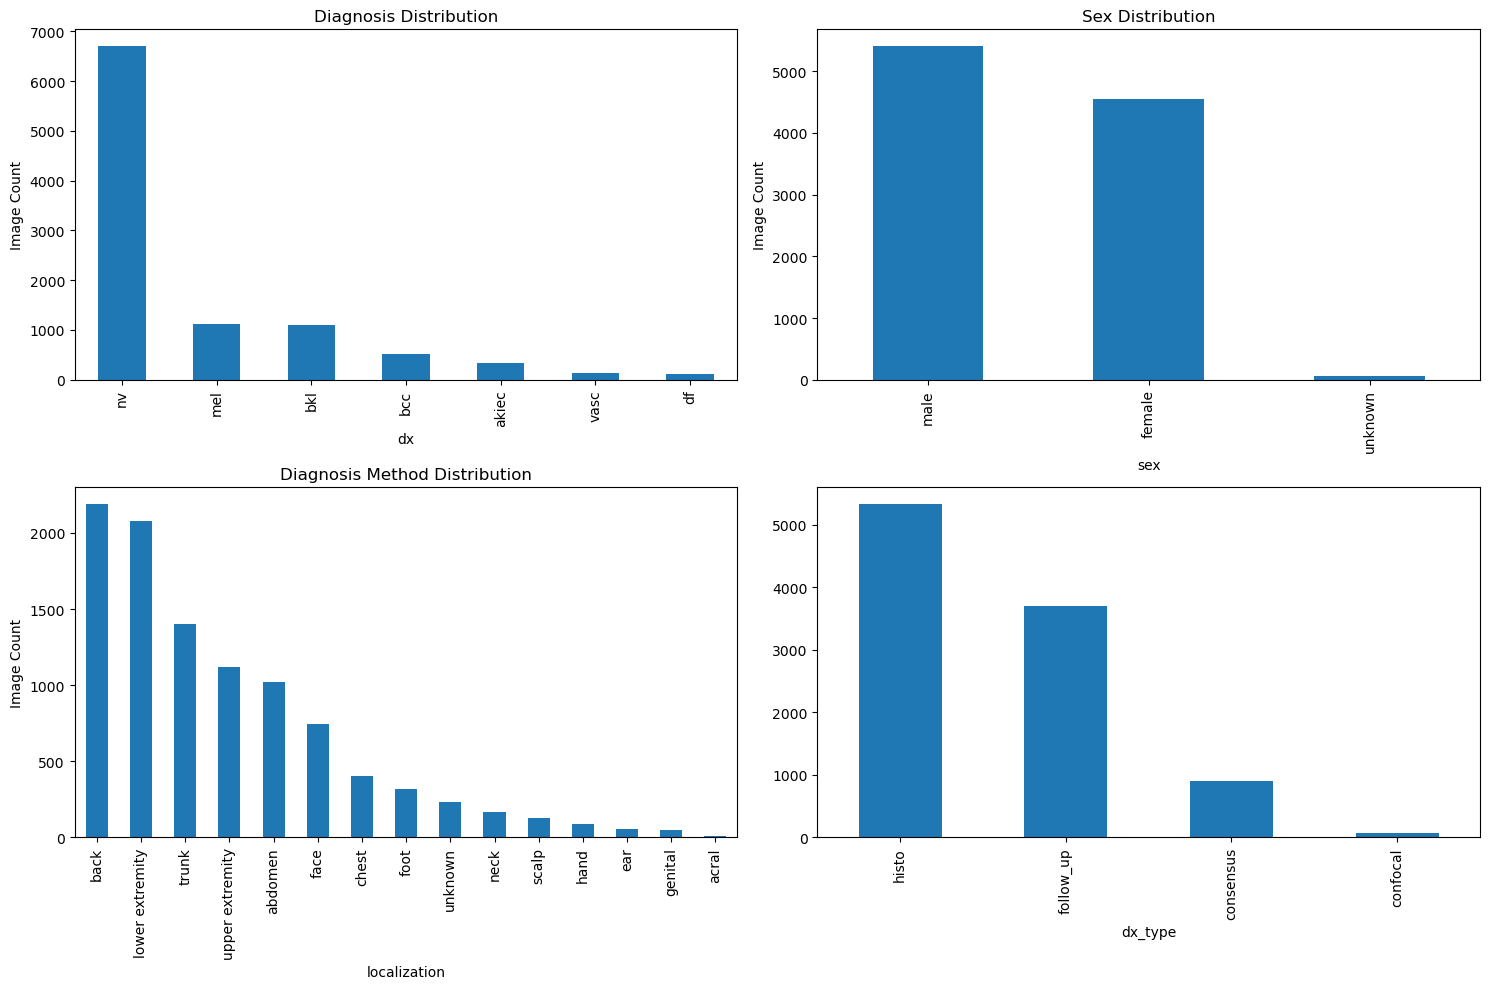

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [2]:
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
fig = plt.figure(figsize=(15, 10))

#Diagnosis Distribution
ax1 = fig.add_subplot(221)
meta_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Diagnosis Distribution')
ax1.set_ylabel('Image Count')

#Sex Distribution
ax2 = fig.add_subplot(222)
meta_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Sex Distribution')
ax2.set_ylabel('Image Count')

#Localization Distribution 
ax3 = fig.add_subplot(223)
meta_data['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Localization Distribution')
ax3.set_ylabel('Image Count')

#Diagnosis Method Distribution 
ax4 = fig.add_subplot(224)
meta_data['dx_type'].value_counts().plot(kind='bar', ax=ax4)
ax3.set_title('Diagnosis Method Distribution')
ax3.set_ylabel('Image Count')

plt.tight_layout()
plt.show()

#Info
print(meta_data.info())

##### Set up Hyper-Parameters

In [10]:
image_width = 224
image_height = 224
batch_size = 32
test_examples = 4637
validation_examples = 4681
train_examples = 33520

##### Initialize Model
- ResNet50 Pretrained

In [11]:
#Empty Model
resnet_model = K.models.Sequential()

#Pretrained Model
pretrained_model = K.applications.ResNet50(
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg', 
    classes=7,
    weights='imagenet'
)

#Set Pretrained Model weights to untrainable
for layer in pretrained_model.layers:
    layer.trainable = False

#Amalgamate our final model
resnet_model.add(pretrained_model)
resnet_model.add(K.layers.Flatten())
resnet_model.add(K.layers.Dense(512, activation='relu'))
resnet_model.add(K.layers.Dense(7, activation='softmax'))

In [12]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24640391 (94.00 MB)
Trainable params: 1052679 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


##### Initialize Data Generators and Data Loaders

In [13]:
#Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [14]:
#Instantiate Data Generators into loaders
train_gen = train_datagen.flow_from_directory(
    "data/reorganized_train",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_gen = test_datagen.flow_from_directory(
    "data/reorganized_test",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
validation_gen = validation_datagen.flow_from_directory(
    "data/reorganized_validation",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 33520 images belonging to 7 classes.
Found 4637 images belonging to 7 classes.
Found 4681 images belonging to 7 classes.


In [22]:
resnet_model.compile(
    optimizer=K.optimizers.Adam(learning_rate=3e-4),
    loss = [K.losses.CategoricalCrossentropy(from_logits=False)],
    metrics = ['accuracy']
    )

##### Train the Model according to Hyper-Parameters.

In [23]:
resnet_model.fit(
    train_gen,
    epochs=100,
    steps_per_epoch=train_examples//batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples//batch_size
)

Epoch 1/10
4/4 [==============================] - 5s 754ms/step - loss: 1.8455 - accuracy: 0.2500 - val_loss: 1.7596 - val_accuracy: 0.2266
Epoch 2/10
4/4 [==============================] - 2s 407ms/step - loss: 1.7949 - accuracy: 0.2422 - val_loss: 1.7875 - val_accuracy: 0.2891
Epoch 3/10
4/4 [==============================] - 2s 423ms/step - loss: 1.7484 - accuracy: 0.3125 - val_loss: 1.7375 - val_accuracy: 0.3047
Epoch 4/10
4/4 [==============================] - 2s 406ms/step - loss: 1.7846 - accuracy: 0.2500 - val_loss: 1.7280 - val_accuracy: 0.3047
Epoch 5/10
4/4 [==============================] - 2s 454ms/step - loss: 1.7733 - accuracy: 0.3281 - val_loss: 1.6980 - val_accuracy: 0.3125
Epoch 6/10
4/4 [==============================] - 2s 541ms/step - loss: 1.7838 - accuracy: 0.2656 - val_loss: 1.6429 - val_accuracy: 0.3594
Epoch 7/10
4/4 [==============================] - 2s 424ms/step - loss: 1.7114 - accuracy: 0.2969 - val_loss: 1.7925 - val_accuracy: 0.2578
Epoch 8/10
4/4 [====

In [21]:
resnet_model.evaluate(validation_gen)
resnet_model.evaluate(test_gen)

145/145 [==============================] - 15s 102ms/step - loss: 1.7569 - accuracy: 0.2549


[1.7568637132644653, 0.25490617752075195]

In [12]:
resnet_model.save("Prototyped_Models/resnet-50_standard.h5", save_format='h5')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Convert to tflite

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()
open("Prototyped_Models/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfjxbw2y9/assets


INFO:tensorflow:Assets written to: /tmp/tmpfjxbw2y9/assets
2024-01-16 02:58:34.332714: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-16 02:58:34.332759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-16 02:58:34.333228: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfjxbw2y9
2024-01-16 02:58:34.355495: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-16 02:58:34.355537: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfjxbw2y9
2024-01-16 02:58:34.398061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-16 02:58:34.422089: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-16 02:58:35.082161: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

98177232

[0. 0. 0. 0. 0. 1. 0.]


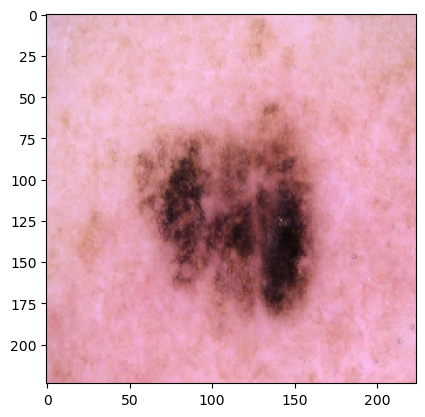

In [51]:
image = test_gen.next()[0][0]
plt.imshow(image)
print(test_gen.next()[1][0])

In [53]:
prediction = resnet_model(image.reshape(1, 224, 224, 3))
print(prediction)

tf.Tensor(
[[0.05520177 0.05561865 0.26406148 0.00994637 0.26749966 0.33800554
  0.00966659]], shape=(1, 7), dtype=float32)
